In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import Estimator
from qiskit.quantum_info import Operator, SparsePauliOp, Statevector
from qiskit.synthesis import LieTrotter, SuzukiTrotter, MatrixExponential
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE

In [7]:
# ======= 在你的 import 之后、函数区里新增这些工具函数 =======

def pauli_basis_change(qc: QuantumCircuit, sys_qubits, label: str):
    """把待测的 Pauli 串 label ∈ {I,X,Y,Z}^n 映射到 Z 基测量。
       X: H； Y: Sdg; H； Z/I: 不动"""
    for q, ch in enumerate(label):
        if ch == 'X':
            qc.h(sys_qubits[q])
        elif ch == 'Y':
            qc.sdg(sys_qubits[q])
            qc.h(sys_qubits[q])
        # Z or I: do nothing

def pauli_value_from_bits(label: str, bits_tuple):
    """给定 Z 基测到的比特 (0/1)，返回该 Pauli 串的本征值乘积（±1）。I 位忽略。"""
    val = 1
    for b, ch in zip(bits_tuple, label):
        if ch == 'I':
            continue
        # Z 基 0-> +1, 1-> -1
        z = +1 if b == 0 else -1
        val *= z
    return val

def int_to_bits_big_endian(x: int, L: int):
    """将整型键转为长度 L 的比特串（大端字符串 -> 元组），适配 Qiskit 计数键。"""
    s = format(x, '0{}b'.format(L))
    return tuple(int(c) for c in s)

def construct_trotter_gate_for_cos(H_cosine: SparsePauliOp, time, order, time_step):
    """保持你原来的阶次/综合器选择，但用于 Y⊗H 的演化门"""
    if order == 0:
        formular = MatrixExponential()
    elif order == 1:
        formular = LieTrotter(reps=time_step)
    else:
        formular = SuzukiTrotter(order=order, reps=time_step)
    return PauliEvolutionGate(H_cosine, time, synthesis=formular)

def build_kstep_circuit(H_cosine: SparsePauliOp, time, nqubits, order, time_step, k_steps,
                        measure_system: bool, pauli_label_for_energy: str = None):
    """
    构建一个动态电路：连续 k_steps 次应用 e^{-i(Y⊗H)t}，
    每一步都测 anc 并 reset 到 |0>，最后可选对 system 做基底变换并测量。
    单一 ClassicalRegister c_all，前 k 步存 anc 测量，后面存 system 测量。
    """
    sys = list(range(nqubits))
    anc = nqubits
    # anc计数 k 位 + 系统 n 位
    c_all = ClassicalRegister(k_steps + nqubits, "c")
    qc = QuantumCircuit(nqubits + 1, c_all)

    evo_gate = construct_trotter_gate_for_cos(H_cosine, time, order, time_step)

    # 初始系统就是 |0...0>，anc 也默认在 |0>
    for i in range(k_steps):
        # 施加 e^{-i*(Y⊗H)*t} 在 anc+system 上
        qc.append(evo_gate, list(range(nqubits + 1)))
        # 测量 anc -> c_all[i]
        qc.measure(anc, c_all[i])
        # 重置 anc 为 |0>
        qc.reset(anc)

    if measure_system:
        # 对系统做基底切换（为某个 Pauli 串），再测量
        assert pauli_label_for_energy is not None and len(pauli_label_for_energy) == nqubits
        pauli_basis_change(qc, sys, pauli_label_for_energy)
        for q in range(nqubits):
            qc.measure(sys[q], c_all[k_steps + q])

    return qc

def parse_counts_for_energy(counts: dict, k_steps: int, nqubits: int, pauli_label: str):
    """
    从 counts（整型键或 bitstring 键都可能，Aer 会给整型键）中：
    1) 只保留 anc 前 k 位全 0 的样本
    2) 提取系统 n 位，换算该 Pauli 串的 ±1 值
    返回：期望值（加权平均）和成功率（保留样本数 / 总样本数）
    """
    # 统计
    kept_num = 0
    kept_weighted_sum = 0.0
    total_shots = sum(counts.values())

    L = k_steps + nqubits  # c_all 总长度
    for key, c in counts.items():
        # AerSimulator 可能返回 int 键，也可能是 str；统一成大端位串 tuple
        if isinstance(key, str):
            bits = tuple(int(ch) for ch in key.replace(' ', ''))  # 已是大端
            if len(bits) != L:
                # 尝试去除空格后的长度不匹配时跳过
                continue
        else:
            # int 键，转成大端
            bits = int_to_bits_big_endian(key, L)

        anc_bits = bits[:k_steps]              # 前 k 位是 anc（我们定义的顺序）
        sys_bits = bits[k_steps:k_steps+nqubits]

        if all(b == 0 for b in anc_bits):
            kept_num += c
            val = pauli_value_from_bits(pauli_label, sys_bits)
            kept_weighted_sum += val * c

    succ_prob = kept_num / total_shots if total_shots > 0 else 0.0
    exp_val = (kept_weighted_sum / kept_num) if kept_num > 0 else 0.0
    return exp_val, succ_prob

def compute_success_prob(simulator, H_cosine, time, nqubits, order, time_step, k_steps, shots=20000):
    """仅测 anc 连续 k 步全 0 的成功率"""
    qc = build_kstep_circuit(H_cosine, time, nqubits, order, time_step, k_steps,
                             measure_system=False)
    tqc = transpile(qc, simulator)
    result = simulator.run(tqc, shots=shots).result()
    counts = result.get_counts(tqc)
    # 用 I^n 作为虚拟 label 解析（只用 anc）
    _, succ = parse_counts_for_energy(counts, k_steps, nqubits, 'I'*nqubits)
    return succ

def estimate_energy_by_sampling(simulator, H_sys: SparsePauliOp,
                                H_cosine: SparsePauliOp,
                                time, nqubits, order, time_step, k_steps,
                                shots_per_term=20000):
    """
    把 H_sys 分解成 Pauli 和：H = Σ_j c_j P_j
    对每个 P_j：
      - 构建 k 步电路 + P_j 的基底切换
      - 采样，后验选择 anc 连续全 0 的子样本
      - 估计 ⟨P_j⟩
    汇总得到 ⟨H⟩ 与（从其中一次计数）得到的成功率
    """
    H_simpl = H_sys.simplify()
    labels = H_simpl.paulis.to_labels()
    coeffs = np.array(H_simpl.coeffs, dtype=complex)

    energy_sum = 0.0
    succ_prob_ref = None

    # 为了稳定，可把同一 k 的“成功率”单独跑一次 compute_success_prob；
    # 这里也可以直接取第一项的 succ 作为代表（理论上与项无关，仅采样噪声差异）
    succ_prob_ref = compute_success_prob(simulator, H_cosine, time, nqubits, order, time_step, k_steps, shots=shots_per_term)

    for lbl, c in zip(labels, coeffs):
        if np.isclose(c, 0.0):
            continue
        # 构建测这个 Pauli 的电路
        qc = build_kstep_circuit(H_cosine, time, nqubits, order, time_step, k_steps,
                                 measure_system=True, pauli_label_for_energy=lbl)
        tqc = transpile(qc, simulator)
        result = simulator.run(tqc, shots=shots_per_term).result()
        counts = result.get_counts(tqc)
        expP, _ = parse_counts_for_energy(counts, k_steps, nqubits, lbl)
        energy_sum += float(np.real(c)) * expP  # H 是厄米的，系数实部即可

    return energy_sum, succ_prob_ref


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import MatrixExponential, LieTrotter, SuzukiTrotter


# ---------- 1) 构造哈密顿量 H（示例：环形 ZZ + X 场） ----------
def get_hamiltonian(nq: int, J: float) -> SparsePauliOp:
    """
    H = J * (sum_i ZZ_{i,i+1})_ring  +  J * (sum_i X_i)
    返回 SparsePauliOp（nq 比特）
    """
    op_list = [("ZZ", [i, (i + 1) % nq], J) for i in range(nq)]   # 环形 ZZ
    op_list += [("X", [i], J) for i in range(nq)]                 # X 场
    return SparsePauliOp.from_sparse_list(op_list, num_qubits=nq).simplify()


# ---------- 2) 基底切换：把要测的 Pauli 串映到 Z 基 ----------
def _pauli_basis_change(qc: QuantumCircuit, sys_reg: QuantumRegister, label: str):
    # X: H；Y: Sdg + H；Z/I: 不动
    for i, ch in enumerate(label):
        if ch == "X":
            qc.h(sys_reg[i])
        elif ch == "Y":
            qc.sdg(sys_reg[i]); qc.h(sys_reg[i])
        # Z / I 不需要操作


# ---------- 3) e^{-i (Y⊗H) t} 的综合器（cosine 过滤的“核”） ----------
def _evo_gate_for_cos(H_sys: SparsePauliOp, time: float, order: int, time_step: int) -> PauliEvolutionGate:
    # order=0: 精确矩阵指数；1: Lie-Trotter；>=2: Suzuki-Trotter
    if order == 0:
        synth = MatrixExponential()
    elif order == 1:
        synth = LieTrotter(reps=time_step)
    else:
        synth = SuzukiTrotter(order=order, reps=time_step)
    # 把 anc 放到最前，作用顺序为 [anc, sys...]
    H_cos = SparsePauliOp(["Y"]) ^ H_sys
    return PauliEvolutionGate(H_cos, time, synthesis=synth)


# ---------- 4) 预览电路：k 步 QRTE（每步测 anc + reset），可选系统测量姿态 ----------
def build_kstep_circuit_preview(
    H_sys: SparsePauliOp,
    time: float,
    nqubits: int,
    order: int,
    time_step: int,
    k_steps: int = 3,
    measure_system: bool = True,
    pauli_label: str | None = None,
) -> QuantumCircuit:
    """
    连续 k_steps 次：
        e^{-i (Y⊗H) t}  ->  测 anc  ->  reset anc
    若 measure_system=True，则在末尾对系统做基底切换并 Z 测量（默认用 H 的第一项做示例）。
    """
    sys_reg = QuantumRegister(nqubits, "sys")
    anc_reg = QuantumRegister(1, "anc")
    c_anc   = ClassicalRegister(k_steps, "c_anc")
    regs = [sys_reg, anc_reg, c_anc]
    if measure_system:
        c_sys = ClassicalRegister(nqubits, "c_sys")
        regs.append(c_sys)

    qc = QuantumCircuit(*regs)
    evo = _evo_gate_for_cos(H_sys, time, order, time_step)

    for i in range(k_steps):
        # 注意线序：我们在 H_cos 里把 anc 放在最前 → append 时也传 [anc, *sys]
        qc.append(evo, [anc_reg[0], *sys_reg])
        qc.measure(anc_reg[0], c_anc[i])
        qc.reset(anc_reg[0])
        qc.barrier()

    if measure_system:
        # 若未指定 pauli_label，则自动用 H 的第一条 Pauli 项做“姿态演示”
        if pauli_label is None:
            labels = H_sys.simplify().paulis.to_labels()
            pauli_label = labels[0] if len(labels) > 0 else "Z" * nqubits
        _pauli_basis_change(qc, sys_reg, pauli_label)
        for q in range(nqubits):
            qc.measure(sys_reg[q], c_sys[q])

    return qc


# ========== 5) 变量取值（与你脚本风格一致） ==========
if __name__ == "__main__":
    nqubits   = 4
    J         = 1.0 / np.sqrt(2)

    # 构造并缩放 H：H_scaled \in [0,1] 区间（和你主脚本一致的缩放方式）
    H0        = get_hamiltonian(nqubits, J)          # SparsePauliOp
    H_mat     = H0.to_matrix()
    evals     = np.linalg.eigvalsh(H_mat)
    emin, emax = float(evals.min()), float(evals.max())
    H_scaled  = (H_mat - emin*np.eye(2**nqubits)) / (emax - emin)
    H         = SparsePauliOp.from_operator(Operator(H_scaled))

    # QRTE / Trotter 参数
    time      = np.pi / 2      # 单步演化时间
    order     = 2              # 0: MatrixExp, 1: Lie-Trotter, >=2: Suzuki
    time_step = 3              # Trotter reps
    k_steps   = 3              # 连续执行 3 次：演化→测 anc→reset

    # ========== 6) 打印电路图 ==========
    # (a) 仅成功率（不测系统）
    qc_prob = build_kstep_circuit_preview(
        H, time, nqubits, order, time_step,
        k_steps=k_steps, measure_system=False
    )
    print("\n[仅成功率：每步 anc 测量+reset]")
    print(qc_prob.draw(output="text", fold=-1))

    # (b) 成功率 + 系统基底切换后的测量姿态（自动用 H 的第一项做示例）
    qc_energy = build_kstep_circuit_preview(
        H, time, nqubits, order, time_step,
        k_steps=k_steps, measure_system=True
        # , pauli_label="XZIZ"  # 想指定某一项可取消注释
    )
    print("\n[成功率 + 基底切换后的系统测量（示例项）]")
    print(qc_energy.draw(output="text", fold=-1))



[仅成功率：每步 anc 测量+reset]
         ┌────────────────────────────────────────────────────────────────────────────────────────┐         ░ ┌────────────────────────────────────────────────────────────────────────────────────────┐         ░ ┌────────────────────────────────────────────────────────────────────────────────────────┐         ░ 
  sys_0: ┤1                                                                                       ├─────────░─┤1                                                                                       ├─────────░─┤1                                                                                       ├─────────░─
         │                                                                                        │         ░ │                                                                                        │         ░ │                                                                                        │         ░ 
  sys_1: ┤2                          

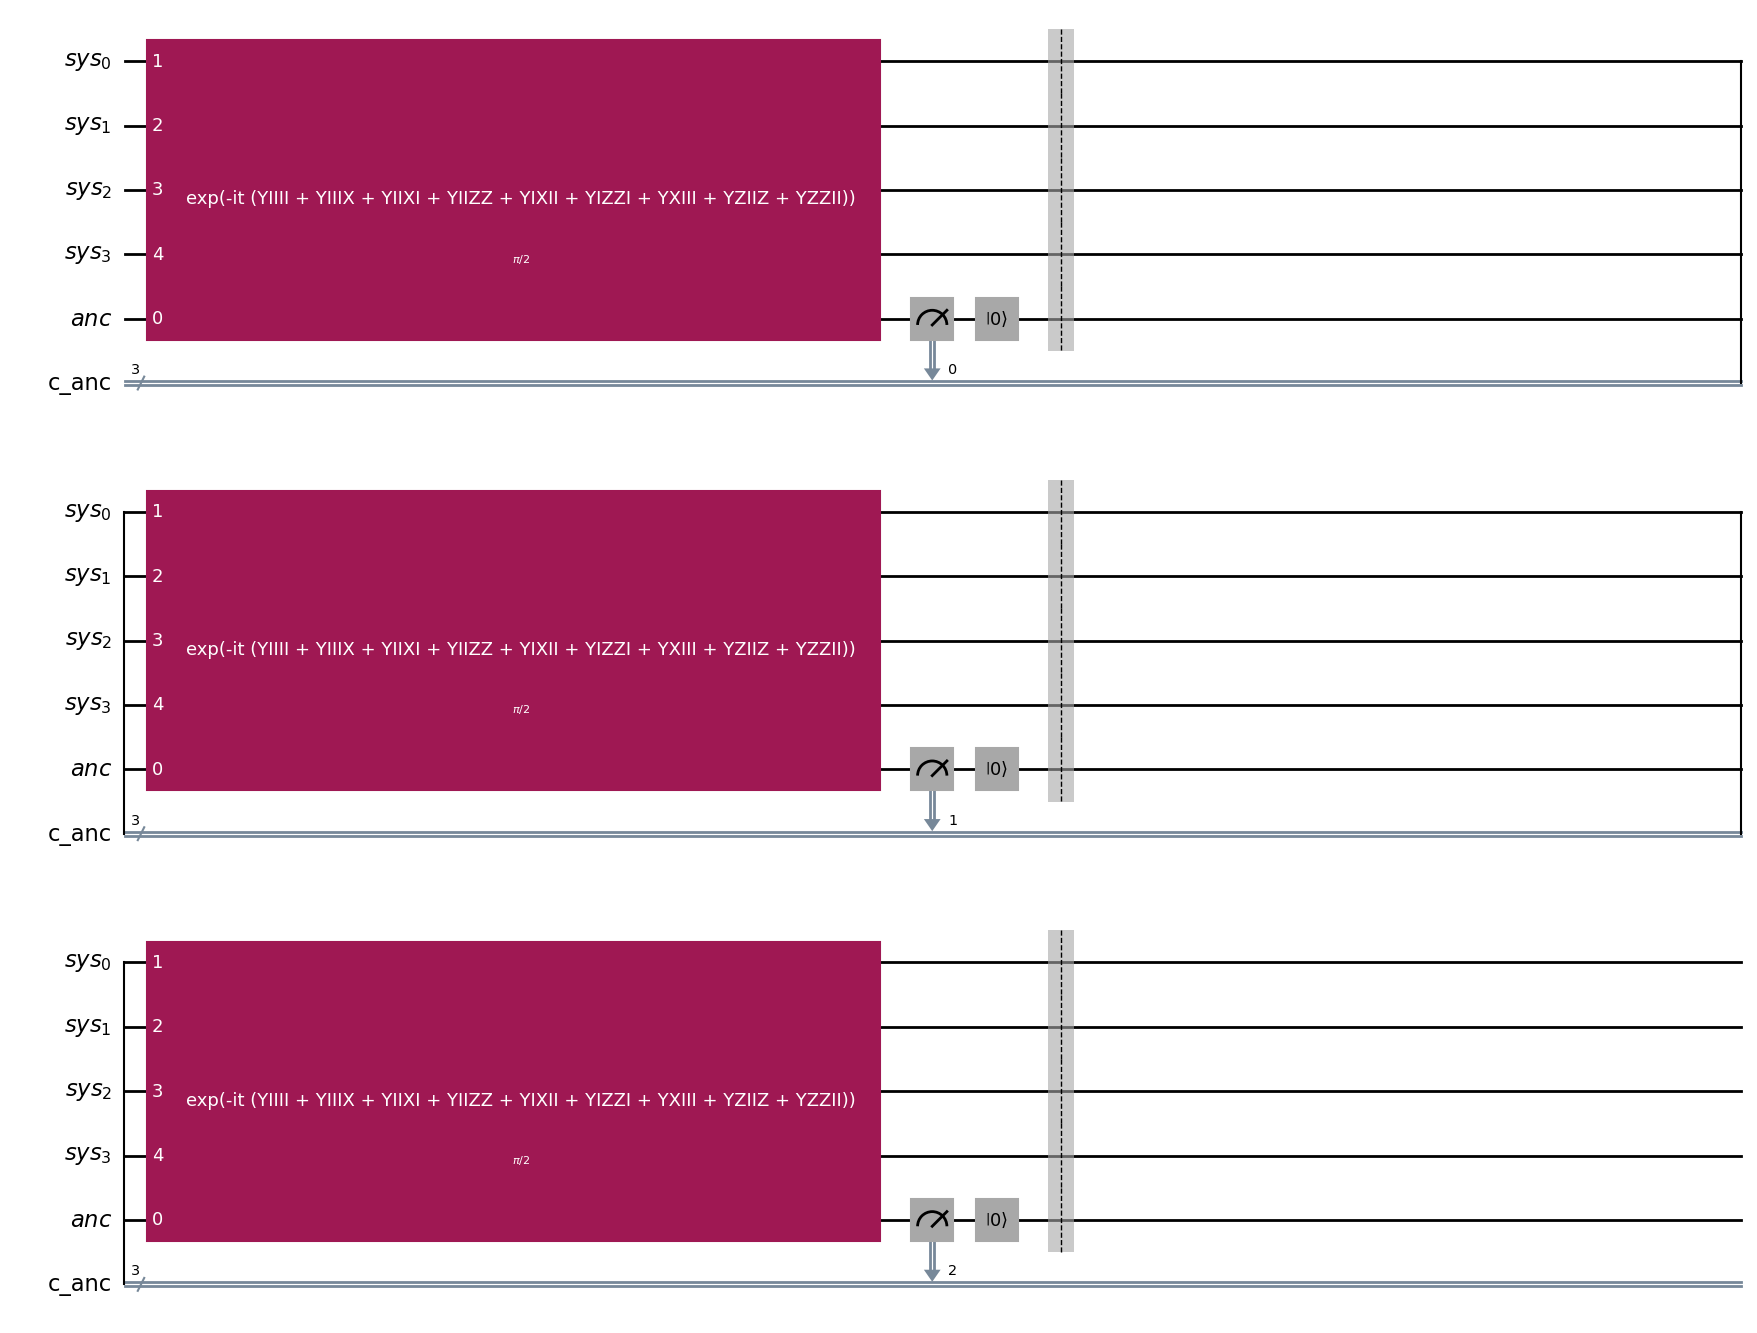

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import MatrixExponential, LieTrotter, SuzukiTrotter


def get_hamiltonian(nq: int, J: float) -> SparsePauliOp:

    op_list = [("ZZ", [i, (i + 1) % nq], J) for i in range(nq)]  # 环形 ZZ
    op_list += [("X", [i], J) for i in range(nq)]                # X 场
    return SparsePauliOp.from_sparse_list(op_list, num_qubits=nq).simplify()


def _pauli_basis_change(qc: QuantumCircuit, sys_reg: QuantumRegister, label: str):
    for i, ch in enumerate(label):
        if ch == "X":
            qc.h(sys_reg[i])
        elif ch == "Y":
            qc.sdg(sys_reg[i]); qc.h(sys_reg[i])


def _evo_gate_for_cos(H_sys: SparsePauliOp, time: float, order: int, time_step: int) -> PauliEvolutionGate:

    if order == 0:
        synth = MatrixExponential()
    elif order == 1:
        synth = LieTrotter(reps=time_step)
    else:
        synth = SuzukiTrotter(order=order, reps=time_step)

    H_cos = SparsePauliOp(["Y"]) ^ H_sys
    return PauliEvolutionGate(H_cos, time, synthesis=synth)

def build_kstep_circuit_preview(
    H_sys: SparsePauliOp,
    time: float,
    nqubits: int,
    order: int,
    time_step: int,
    k_steps: int = 3,
    measure_system: bool = True,
    pauli_label: str | None = None,
) -> QuantumCircuit:

    sys_reg = QuantumRegister(nqubits, "sys")
    anc_reg = QuantumRegister(1, "anc")
    c_anc   = ClassicalRegister(k_steps, "c_anc")
    regs = [sys_reg, anc_reg, c_anc]
    if measure_system:
        c_sys = ClassicalRegister(nqubits, "c_sys")
        regs.append(c_sys)

    qc = QuantumCircuit(*regs)
    evo = _evo_gate_for_cos(H_sys, time, order, time_step)

    for i in range(k_steps):

        qc.append(evo, [anc_reg[0], *sys_reg])
        qc.measure(anc_reg[0], c_anc[i])
        qc.reset(anc_reg[0])
        qc.barrier()

    if measure_system:

        if pauli_label is None:
            labels = H_sys.simplify().paulis.to_labels()
            pauli_label = labels[0] if len(labels) > 0 else "Z" * nqubits
        _pauli_basis_change(qc, sys_reg, pauli_label)
        for q in range(nqubits):
            qc.measure(sys_reg[q], c_sys[q])

    return qc


nqubits   = 4
J         = 1.0 / np.sqrt(2)


H0        = get_hamiltonian(nqubits, J)
H_mat     = H0.to_matrix()
evals     = np.linalg.eigvalsh(H_mat)
emin, emax = float(evals.min()), float(evals.max())
H_scaled  = (H_mat - emin*np.eye(2**nqubits)) / (emax - emin)
H         = SparsePauliOp.from_operator(Operator(H_scaled))


time      = np.pi / 2
order     = 2
time_step = 3
k_steps   = 3

qc_prob = build_kstep_circuit_preview(
    H, time, nqubits, order, time_step,
    k_steps=k_steps, measure_system=False
)
qc_prob.draw(output="mpl")



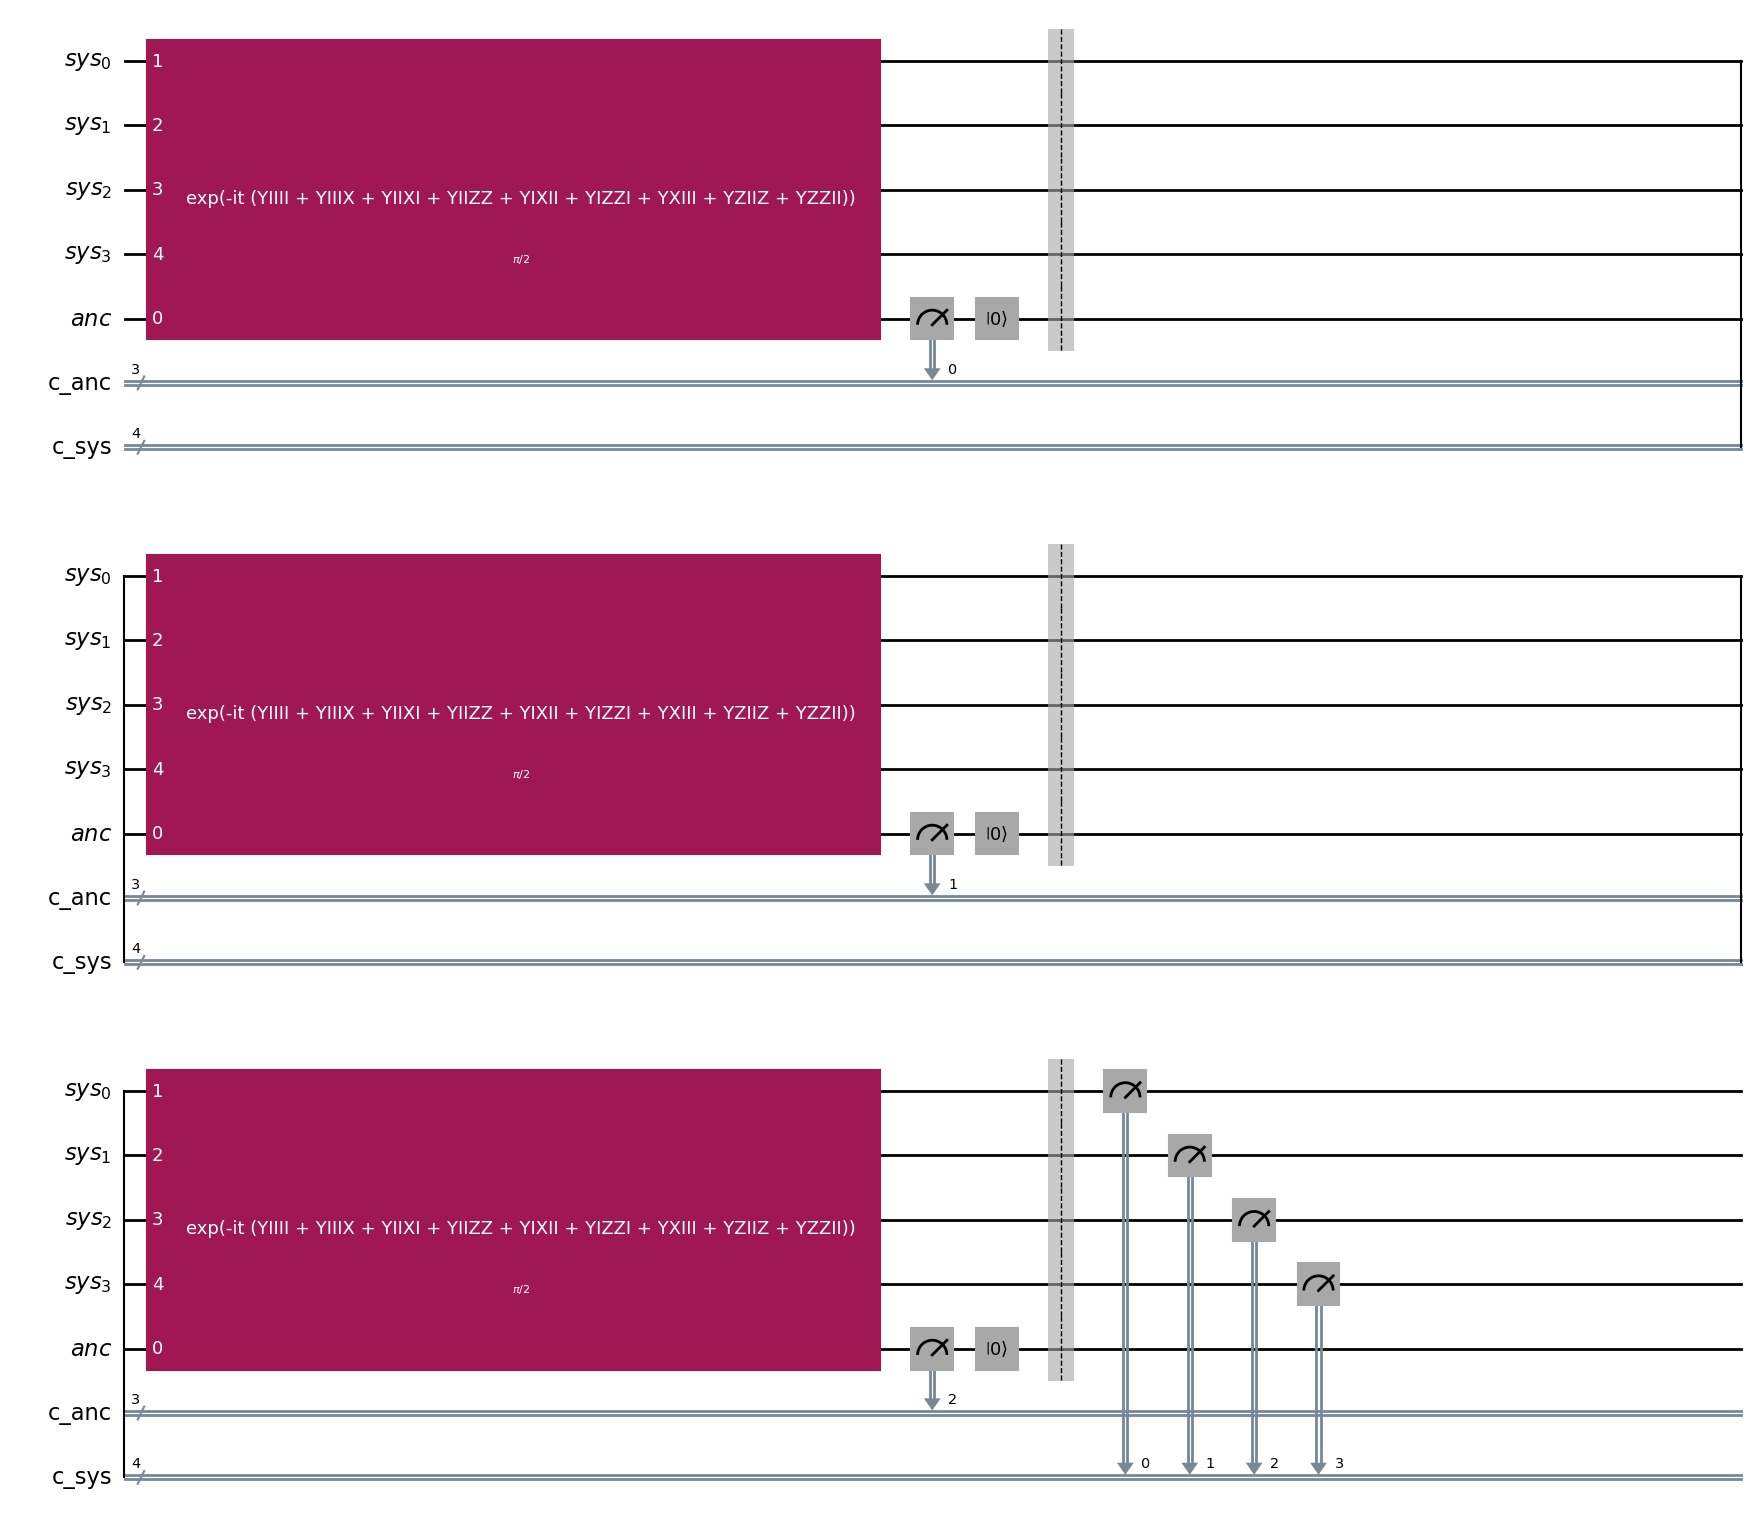

In [16]:

qc_energy = build_kstep_circuit_preview(
    H, time, nqubits, order, time_step,
    k_steps=k_steps, measure_system=True
)
qc_energy.draw(output="mpl")


In [19]:
import numpy as np
from collections import Counter

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.synthesis import MatrixExponential, LieTrotter, SuzukiTrotter
from qiskit_aer import AerSimulator

# —— H：环形 ZZ + X 场 ——
def get_hamiltonian(nq: int, J: float) -> SparsePauliOp:
    ops = [("ZZ", [i, (i+1) % nq], J) for i in range(nq)]
    ops += [("X", [i], J) for i in range(nq)]
    return SparsePauliOp.from_sparse_list(ops, num_qubits=nq).simplify()

# —— e^{-i (Y_anc ⊗ H_sys) t} ——
def evo_gate_for_cos(H_sys: SparsePauliOp, time: float, order: int, time_step: int):
    if order == 0:
        synth = MatrixExponential()
    elif order == 1:
        synth = LieTrotter(reps=time_step)
    else:
        synth = SuzukiTrotter(order=order, reps=time_step)
    H_cos = SparsePauliOp(["Y"]) ^ H_sys   # anc ⊗ system
    return PauliEvolutionGate(H_cos, time, synthesis=synth)

# —— 测 Pauli 串的基底切换 ——
def pauli_basis_change(qc: QuantumCircuit, sys_reg: QuantumRegister, label: str):
    for i, ch in enumerate(label):
        if ch == "X":
            qc.h(sys_reg[i])
        elif ch == "Y":
            qc.sdg(sys_reg[i]); qc.h(sys_reg[i])

# —— 从比特串算本征值 v_j(b) ——
def eigen_value_from_bits(label: str, bits):
    v = 1
    for bit, ch in zip(bits, label):
        if ch == "I":
            continue
        v *= (1 if bit == 0 else -1)
    return v

# —— 构电路：先准备 |+>^n（H 层），再 1 步 QRTE；可选：为某个 Pauli 串做基底切换并测量 ——
def circuit_for_label_simple(n_sys, H_sys, time, order, time_step, label=None):
    anc = QuantumRegister(1, "anc")
    sys = QuantumRegister(n_sys, "sys")
    c_anc = ClassicalRegister(1, "c_anc")
    c_sys = ClassicalRegister(n_sys, "c_sys")
    qc = QuantumCircuit(anc, sys, c_anc, c_sys)

    # 初态：系统比特 H 层得到 |+>^n；anc 默认 |0>
    for q in range(n_sys):
        qc.h(sys[q])

    # 一步 QRTE
    evo = evo_gate_for_cos(H_sys, time, order, time_step)
    qc.append(evo, [anc[0], *sys])

    # 若需要测某个 Pauli 项：先基底切换，再测 anc+system（Z 基）
    if label is not None:
        pauli_basis_change(qc, sys, label)
        qc.measure(anc[0], c_anc[0])
        for i in range(n_sys):
            qc.measure(sys[i], c_sys[i])

    return qc

# —— counts + 后选（anc=0）计算 E_cond 与 p_succ ——
def energy_from_counts(n_sys, H_sys, time, order, time_step, shots=200_000, seed=1):
    Hs = H_sys.simplify()
    labels = Hs.paulis.to_labels()
    coeffs = np.real(Hs.coeffs)

    sim = AerSimulator(seed_simulator=seed)
    N0_total = 0
    num_sum = 0.0
    used_terms = 0

    for lbl, c in zip(labels, coeffs):
        if abs(c) < 1e-12:
            continue
        used_terms += 1
        qc = circuit_for_label_simple(n_sys, H_sys, time, order, time_step, label=lbl)
        tqc = transpile(qc, sim)
        res = sim.run(tqc, shots=shots, memory=True).result()
        mem = [s.replace(" ", "") for s in res.get_memory(tqc)]  # 形如 "a bbbbb" → 去空格

        N0, S = 0, 0
        for s in mem:
            anc_bit = int(s[0])                      # anc 在最前
            sys_bits = tuple(int(ch) for ch in s[1:1+n_sys])
            if anc_bit == 0:
                N0 += 1
                S += eigen_value_from_bits(lbl, sys_bits)
        N0_total += N0
        num_sum  += c * S

    if N0_total == 0:
        return np.nan, 0.0
    E_cond = num_sum / N0_total
    p_succ = N0_total / (shots * max(1, used_terms))
    return E_cond, p_succ

# —— statevector + 投影（anc=0）计算 E_cond 与 p_succ ——
def energy_from_statevector(n_sys, H_sys, time, order, time_step):
    # 同一幺正（不含测量）：H 层 → 1 步 QRTE
    qc_u = circuit_for_label_simple(n_sys, H_sys, time, order, time_step, label=None)
    sv = Statevector.from_label("0" * (1 + n_sys)).evolve(qc_u)
    vec = sv.data

    dim = 2 ** n_sys
    phi = vec[:dim]                         # anc=0 的分量（anc 在最前 → 前半段）
    p_succ = float(np.vdot(phi, phi).real)
    if p_succ == 0.0:
        return np.nan, 0.0

    psi_sys = phi / np.sqrt(p_succ)
    Hmat = H_sys.to_matrix()
    E = float(np.vdot(psi_sys, Hmat @ psi_sys).real)
    return E, p_succ


In [21]:
# 问题规模与哈密顿量
n_sys = 4
J = 1.0 / np.sqrt(2)
H0 = get_hamiltonian(n_sys, J)

# 可选：把谱缩放到 [0,1]（与你之前脚本一致）
Hmat = H0.to_matrix()
evals = np.linalg.eigvalsh(Hmat)
emin, emax = float(evals.min()), float(evals.max())
H_scaled = (Hmat - emin*np.eye(2**n_sys)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_scaled))

# QRTE / Trotter 参数
time = np.pi / 2
order = 2          # 0: MatrixExp, 1: Lie, >=2: Suzuki
time_step = 3

# （A）counts + 后选（anc=0）
E_counts, p_counts = energy_from_counts(n_sys, H, time, order, time_step, shots=200_000, seed=42)

# （B）statevector + 投影（anc=0）
E_state, p_state = energy_from_statevector(n_sys, H, time, order, time_step)

print(f"E_cond (counts)      = {E_counts:.6f}   |  p_succ = {p_counts:.6f}")
print(f"E_cond (statevector) = {E_state:.6f}   |  p_succ = {p_state:.6f}")
print(f"ΔE = {abs(E_counts - E_state):.6e} ,  Δp = {abs(p_counts - p_state):.6e}")


E_cond (counts)      = 0.098926   |  p_succ = 0.253682
E_cond (statevector) = 0.903152   |  p_succ = 0.264217
ΔE = 8.042260e-01 ,  Δp = 1.053576e-02


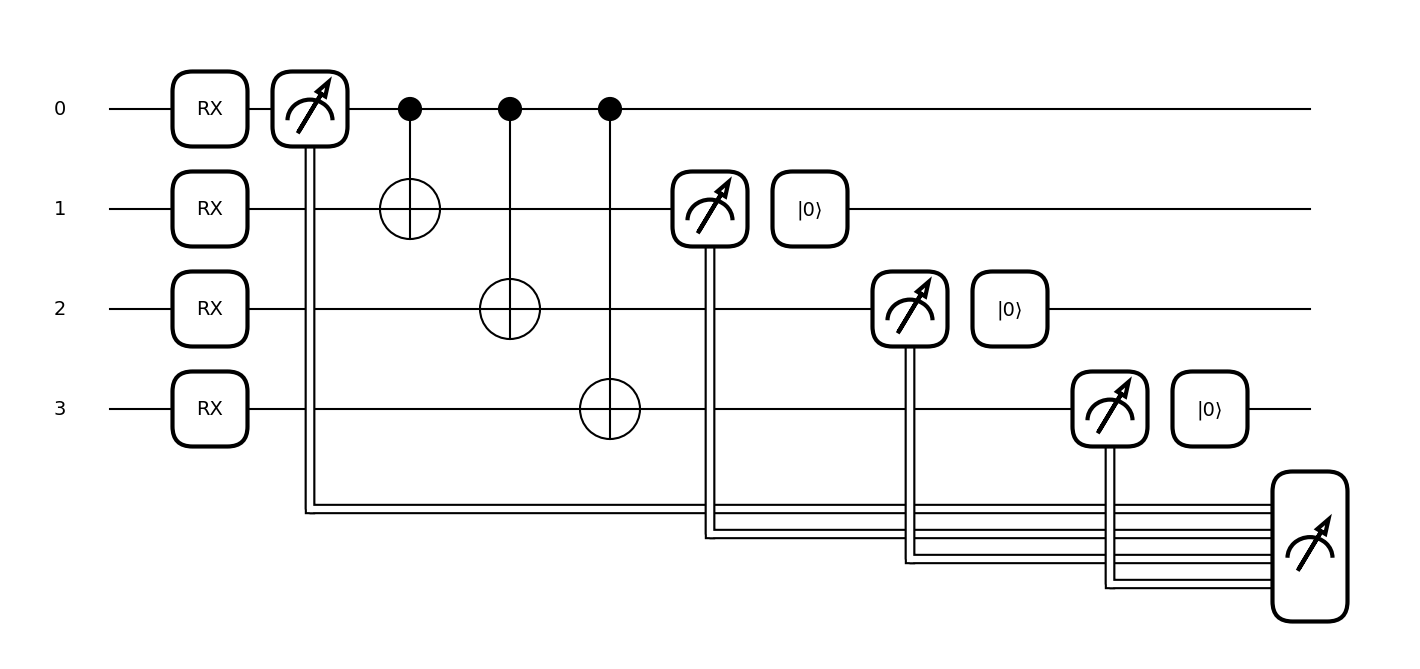

In [25]:
import pennylane as qml
import numpy as np

np.random.seed(511)

first_wire = 0
other_wires = [1, 2, 3]


def ansatz(x):
    mcms = []

    # Rotate all qubits
    for w, x_ in enumerate(x):
        qml.RX(x_, w)

    # Measure first qubit
    mcms.append(qml.measure(first_wire))

    # Entangle all qubits with first qubit
    for w in other_wires:
        qml.CNOT([first_wire, w])

    # Measure and reset all qubits but the first
    for w in other_wires:
        mcms.append(qml.measure(w, reset=True))

    return mcms

dev = qml.device("default.qubit", shots=100)


@qml.qnode(dev)
def simple_node(x):
    # apply the ansatz, and collect mid-circuit measurements. mcm1 is the measurement
    # of wire 0, and mcms2 is a list of measurements of the other wires.
    mcm1, *mcms2 = ansatz(x)
    return qml.probs(op=mcm1), qml.counts(mcms2)

x = np.random.random(4)
fig, ax = qml.draw_mpl(simple_node)(x)

In [26]:
probs, counts = qml.defer_measurements(simple_node)(x)
print(f"Probability vector of first qubit MCM: {np.round(probs, 5)}")
print(f"Bit string counts on other qubits: {counts}")

Probability vector of first qubit MCM: [0.8 0.2]
Bit string counts on other qubits: {np.str_('000'): np.int64(71), np.str_('011'): np.int64(8), np.str_('100'): np.int64(9), np.str_('111'): np.int64(12)}


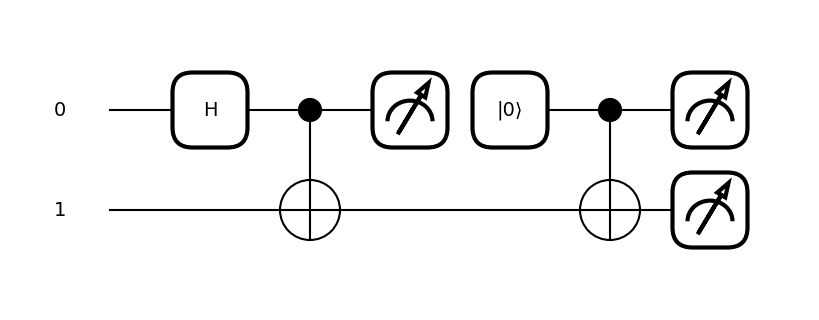

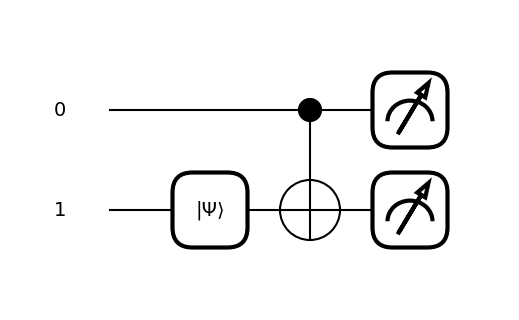

In [84]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# ========== 电路 A：H -> CNOT -> (measure+reset on q0) -> CNOT ==========
devA = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(devA)
def circuit_A_for_draw():
    qml.H(0)
    qml.CNOT([0, 1])
    m = qml.measure(0, reset=True)
    qml.CNOT([0, 1])
    return qml.probs(wires=[0, 1])

figA = qml.draw_mpl(circuit_A_for_draw)()


# ========== 电路 B：postselect q0=0 后，准备 |0>⊗|post_q1>，再 CNOT ==========
dev_tmp = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(dev_tmp)
def pre_state():
    qml.H(0)
    qml.CNOT([0, 1])
    return qml.state()

psi = pre_state()
post_q1 = np.array([psi[0], psi[1]], dtype=complex)
post_q1 = post_q1 / np.linalg.norm(post_q1)

devB = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(devB)
def circuit_B_for_draw(state_q1):
    # q0 默认是 |0>，在 q1 上准备后选态
    qml.StatePrep(state_q1, wires=1)
    qml.CNOT([0, 1])
    return qml.probs(wires=[0, 1])

figB = qml.draw_mpl(circuit_B_for_draw)(post_q1)



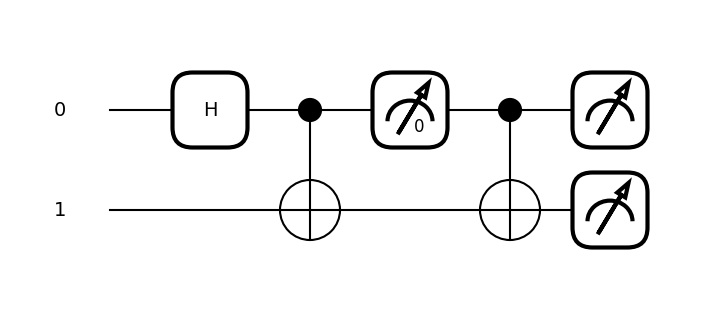

In [85]:
devC = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(devC)
def circuit_C_for_draw():
    qml.H(0)
    qml.CNOT([0, 1])
    m = qml.measure(0, postselect=0)
    qml.CNOT([0, 1])
    return qml.probs(wires=[0, 1])

figC = qml.draw_mpl(circuit_C_for_draw)()

In [64]:
devA = qml.device("default.qubit", wires=3, shots=None)

@qml.qnode(devA)
def circuit_A():
    qml.H(0)
    qml.CNOT([0, 1])
    m = qml.measure(0, reset=True)
    qml.CNOT([0, 1])
    return qml.probs(wires=[0, 1])


In [65]:
circuit_A()

array([0.5, 0.5, 0. , 0. ])

(<Figure size 800x300 with 1 Axes>, <Axes: >)

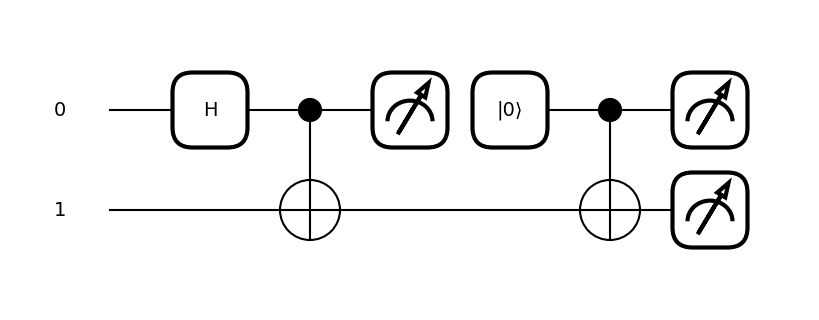

In [70]:
qml.draw_mpl(circuit_A)()

In [82]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# ========== 帮助函数 ==========
def build_postselected_q1():
    """生成 H->CNOT 之后的两比特态，并抽取 q0=0 分支下 q1 的态 |post_q1>。"""
    dev_tmp = qml.device("default.qubit", wires=[0, 1], shots=None)

    @qml.qnode(dev_tmp)
    def pre_state():
        qml.H(0)
        qml.CNOT([0, 1])
        return qml.state()

    psi = pre_state()  # 顺序 |q0 q1>
    post_q1 = np.array([psi[0], psi[1]], dtype=complex)
    post_q1 = post_q1 / np.linalg.norm(post_q1)
    return post_q1

post_q1 = build_postselected_q1()

# ========== 数值运行（与画图分开，使用 default.mixed 以稳妥支持 mid-circuit） ==========
devA = qml.device("default.mixed", wires=[0, 1, 2], shots=None)
devB = qml.device("default.mixed", wires=[0, 1], shots=None)

@qml.qnode(devA)
def circuit_A():
    qml.H(0)
    qml.CNOT([0, 1])
    qml.measure(0, reset=True)
    qml.CNOT([0, 1])
    return (
        qml.probs(wires=[0]),
        qml.expval(qml.PauliZ(0)),
        qml.expval(qml.PauliZ(1)),
    )

@qml.qnode(devB)
def circuit_B(state_q1):
    qml.StatePrep(state_q1, wires=1)
    qml.CNOT([0, 1])
    return (
        qml.probs(wires=[0]),
        qml.expval(qml.PauliZ(0)),
        qml.expval(qml.PauliZ(1)),
    )

devC = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(devC)
def circuit_C():
    qml.H(0)
    qml.CNOT([0, 1])
    m = qml.measure(0, postselect=0)
    qml.CNOT([0, 1])
    return qml.probs(wires=[0]), qml.expval(qml.PauliZ(1))


probs_A, z0_A, z1_A = circuit_A()
probs_B, z0_B, z1_B = circuit_B(post_q1)
result_C = circuit_C()
np.set_printoptions(precision=3, suppress=True)
print("=== Probability distributions (|00>,|01>,|10>,|11>) ===")
print("Circuit A:", probs_A)
print("Circuit B:", probs_B)

print("\n=== Z expectations ===")
print(f"Circuit A: <Z⊗I>={z0_A:.3f}, <I⊗Z>={z1_A:.3f}")
print(f"Circuit B: <Z⊗I>={z0_B:.3f}, <I⊗Z>={z1_B:.3f}")


=== Probability distributions (|00>,|01>,|10>,|11>) ===
Circuit A: [1. 0.]
Circuit B: [1. 0.]

=== Z expectations ===
Circuit A: <Z⊗I>=1.000, <I⊗Z>=0.000
Circuit B: <Z⊗I>=1.000, <I⊗Z>=1.000


(<Figure size 700x300 with 1 Axes>, <Axes: >)


(array([1., 0.]), array(1.))

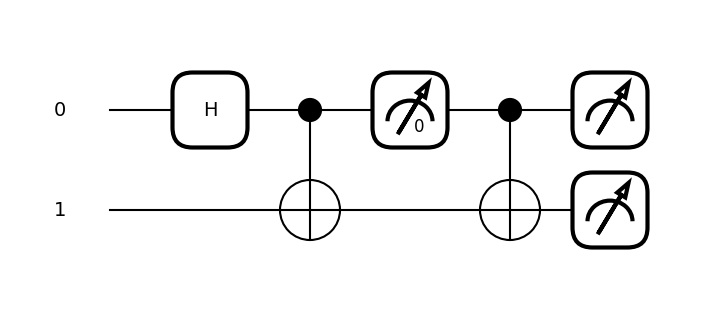

In [81]:
devC = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(devC)
def circuit_C():
    qml.H(0)
    qml.CNOT([0, 1])
    m = qml.measure(0, postselect=0)
    qml.CNOT([0, 1])
    return qml.probs(wires=[0]), qml.expval(qml.PauliZ(1))

print(qml.draw_mpl(circuit_C)())
circuit_C()

In [83]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# ---------- 帮助函数：构造 postselect(q0=0) 后的 q1 单比特态 ----------
def build_postselected_q1():
    dev_tmp = qml.device("default.qubit", wires=[0, 1], shots=None)

    @qml.qnode(dev_tmp)
    def pre_state():
        qml.H(0)
        qml.CNOT([0, 1])
        return qml.state()

    psi = pre_state()  # |q0 q1>
    post_q1 = np.array([psi[0], psi[1]], dtype=complex)
    post_q1 = post_q1 / np.linalg.norm(post_q1)
    return post_q1

post_q1 = build_postselected_q1()

# ========== A：用纯化来得到“等效”的三比特 state vector ==========
# 目标：等效于 H->CNOT->(measure q0 + reset)->CNOT 的输出。
# 纯化思路：
#   |Φ+> = (|00>+|11>)/√2
#   1) 用 CNOT(1->0) 把 q0 置成 |0>，得到 |0>⊗|+>
#   2) 用 CNOT(1->2) 把 q1 与环境 entangle，q1 退相干成 I/2
#   3) 再做 CNOT(0->1)（与原电路最后一步对齐，但此时 q0=|0> 不起作用）
devA_pure = qml.device("default.qubit", wires=[0, 1, 2], shots=None)

@qml.qnode(devA_pure)
def circuit_A_statevec_purified():
    qml.H(0)
    qml.CNOT([0, 1])      # 得到 Bell
    qml.CNOT([1, 0])      # 把 q0 变为 |0>，q1 变为 |+>
    qml.CNOT([1, 2])      # 与环境线纠缠 => q1 退相干（等效于测量+reset 的效果在 q1 上留下混合）
    qml.CNOT([0, 1])      # 与原电路最后一步对应（此时无效，因为 q0=|0>）
    return qml.state()     # 三比特纯态 |0>⊗( |0>_1|0>_e + |1>_1|1>_e )/√2

state_A = circuit_A_statevec_purified()   # 维度 8 的 state vector（3 根线）

# ========== B：与原描述一致，返回两比特 state vector ==========
devB = qml.device("default.qubit", wires=[0, 1], shots=None)

@qml.qnode(devB)
def circuit_B_statevec(state_q1):
    qml.StatePrep(state_q1, wires=1)  # |0>⊗|post_q1>
    qml.CNOT([0, 1])
    return qml.state()

state_B = circuit_B_statevec(post_q1)    # 维度 4 的 state vector（2 根线）

# ========== C：postselect(q0=0) 后再 CNOT，等价于最终 |00>，直接返回两比特 state vector ==========
devC = qml.device("default.qubit", wires=[0, 1], shots=None)

@qml.qnode(devC)
def circuit_C_statevec_equiv():
    # H->CNOT 得到 |Φ+>，postselect q0=0 保留 |00>，再 CNOT 仍是 |00>
    # 因此可直接制备 |00> 作为等效纯态
    return qml.state()  # 设备初态就是 |00>

state_C = circuit_C_statevec_equiv()

# ========== 打印核对 ==========
np.set_printoptions(precision=3, suppress=True)

print("State A (purified, wires [0,1,2]):")
print(np.round(state_A, 6))        # 长度 8
print("\nState B (wires [0,1]):")
print(np.round(state_B, 6))        # 长度 4
print("\nState C (wires [0,1]):")
print(np.round(state_C, 6))        # 长度 4  => [1,0,0,0]ᵀ 即 |00>


State A (purified, wires [0,1,2]):
[0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j 0.   +0.j 0.   +0.j 0.   +0.j
 0.   +0.j]

State B (wires [0,1]):
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]

State C (wires [0,1]):
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [87]:
import numpy as np
import pennylane as qml

# ---------- helper: postselect(q0=0) to get q1's state ----------
def build_postselected_q1():
    dev_tmp = qml.device("default.qubit", wires=[0, 1], shots=None)

    @qml.qnode(dev_tmp)
    def pre_state():
        qml.H(0)
        qml.CNOT([0, 1])
        return qml.state()

    psi = pre_state()  # state on wires [0,1]
    post_q1 = np.array([psi[0], psi[1]], dtype=complex)  # amplitudes with q0=0 → |00>,|01>
    post_q1 = post_q1 / np.linalg.norm(post_q1)
    return post_q1

post_q1 = build_postselected_q1()


# ========== 电路 A：H -> CNOT -> (measure+reset on q0) -> CNOT ==========
devA = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(devA)
def circuit_A_Zexp():
    qml.H(0)
    qml.CNOT([0, 1])
    m = qml.measure(0, reset=True)
    qml.CNOT([0, 1])
    return (qml.expval(qml.Z(0)),
            qml.expval(qml.Z(1)),
            qml.expval(qml.Z(0) @ qml.Z(1)))

# ========== B: two-qubit equivalent, return Z expectations ==========
devB = qml.device("default.qubit", wires=[0, 1], shots=None)

@qml.qnode(devB)
def circuit_B_Zexp(state_q1):
    qml.StatePrep(state_q1, wires=1)  # |0> ⊗ |post_q1>
    qml.CNOT([0, 1])
    return (qml.expval(qml.Z(0)),
            qml.expval(qml.Z(1)),
            qml.expval(qml.Z(0) @ qml.Z(1)))

# ========== C: direct equivalent (final is |00>), return Z expectations ==========
devC = qml.device("default.qubit", wires=[0, 1], shots=None)

@qml.qnode(devC)
def circuit_C_Zexp():
    # equivalent final state is |00>
    return (qml.expval(qml.Z(0)),
            qml.expval(qml.Z(1)),
            qml.expval(qml.Z(0) @ qml.Z(1)))

# ---------- run & print ----------
ZA = circuit_A_Zexp()
ZB = circuit_B_Zexp(post_q1)
ZC = circuit_C_Zexp()

print("A: <Z0>, <Z1>, <Z2>, <Z0Z1>, <Z1Z2> =", [float(x) for x in ZA])
print("B: <Z0>, <Z1>, <Z0Z1>               =", [float(x) for x in ZB])
print("C: <Z0>, <Z1>, <Z0Z1>               =", [float(x) for x in ZC])


A: <Z0>, <Z1>, <Z2>, <Z0Z1>, <Z1Z2> = [0.9999999999999998, 0.0, 0.0]
B: <Z0>, <Z1>, <Z0Z1>               = [1.0, 1.0, 1.0]
C: <Z0>, <Z1>, <Z0Z1>               = [1.0, 1.0, 1.0]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

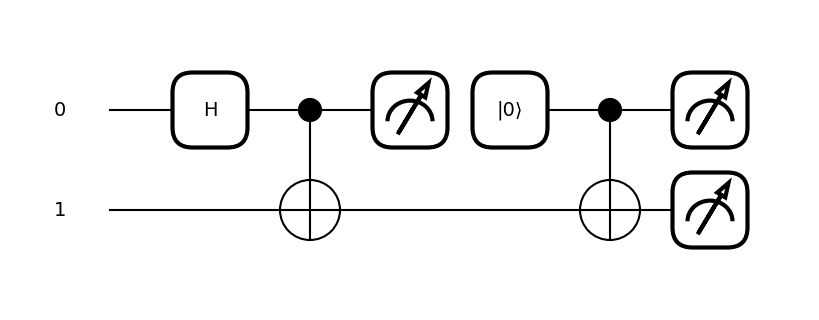

In [89]:
qml.draw_mpl(circuit_A_Zexp)()